In [2]:
import numpy as np
import matplotlib.pyplot as plt
from problem_1.FEMpoisson import FEMPoissonSolver
from problem_2.OCP import FEMSolver



                              Convergence Analysis                              
    M         h      L2 Error  Rate L2   Ratio L2  H1 Error  Rate H1   Ratio H1 
--------------------------------------------------------------------------------
    2      5.00e-01  3.20e-17     -         -      6.00e-17     -         -     
    4      2.50e-01  8.81e-17   -1.46      0.36    1.66e-16   -1.47      0.36   
    8      1.25e-01  3.73e-16   -2.08      0.24    6.99e-16   -2.07      0.24   
    16     6.25e-02  1.83e-15   -2.30      0.20    3.42e-15   -2.29      0.20   
    32     3.12e-02  7.05e-15   -1.94      0.26    1.31e-14   -1.94      0.26   
    64     1.56e-02  2.83e-14   -2.01      0.25    5.28e-14   -2.01      0.25   
   128     7.81e-03  1.06e-13   -1.91      0.27    1.98e-13   -1.91      0.27   
Overall convergence rates - L2: -2.00, H1: -2.00
Final errors - L2: 1.06e-13, H1: 1.98e-13



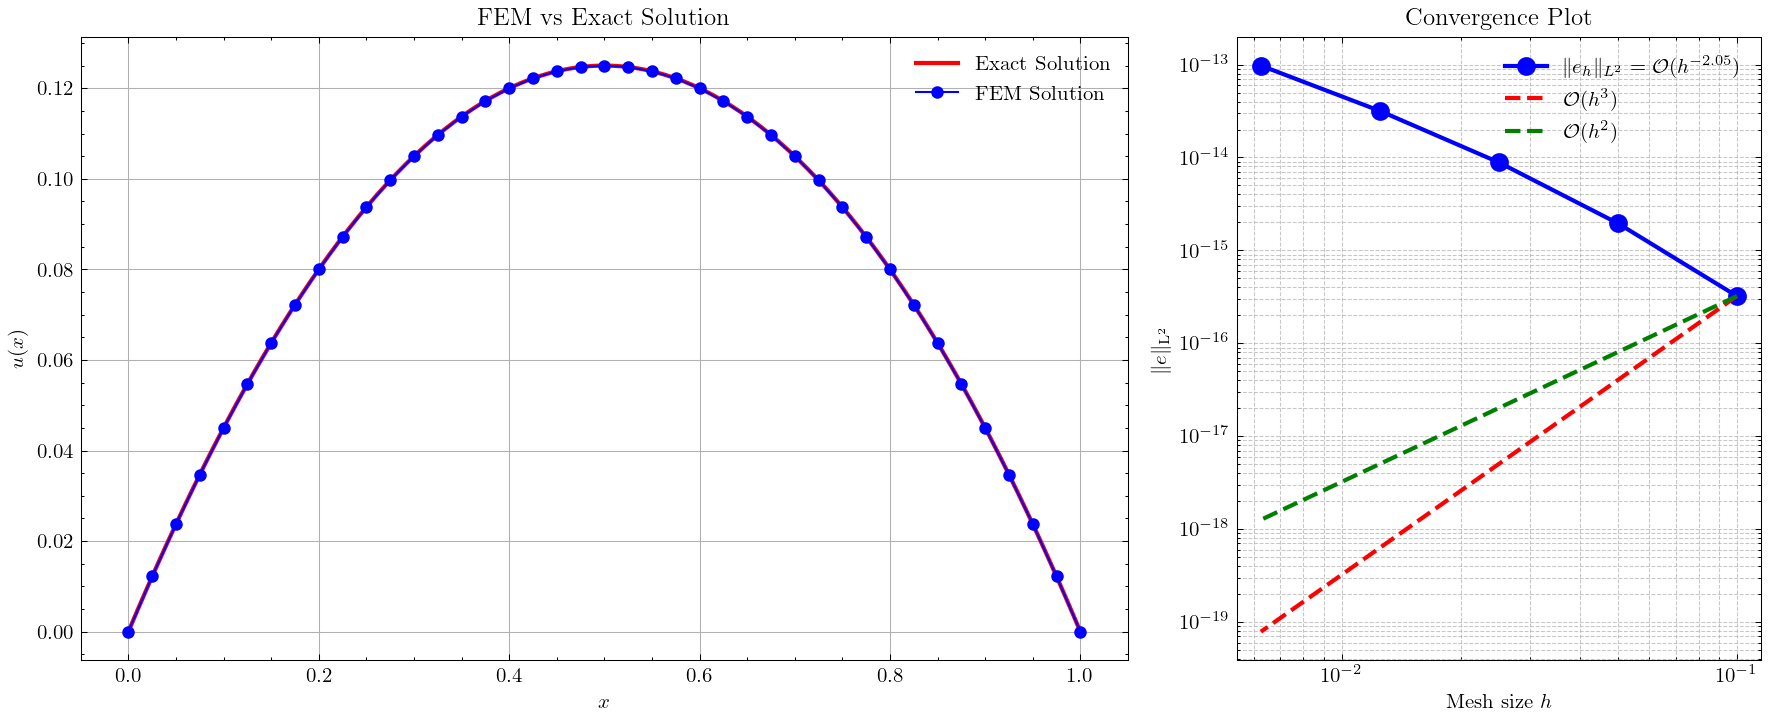

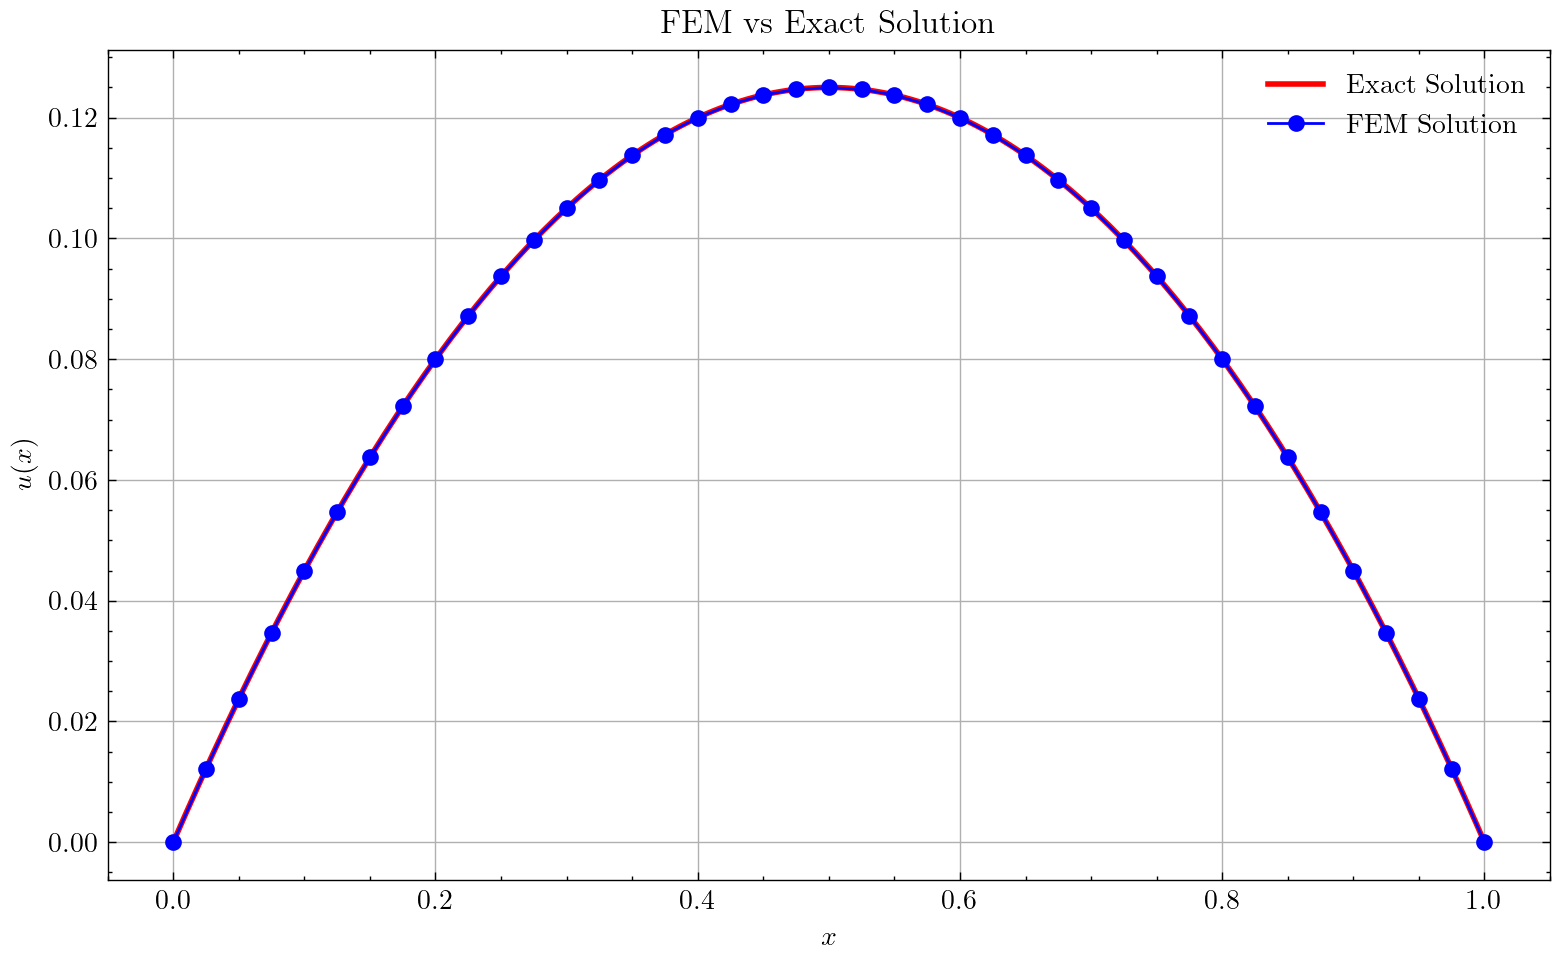

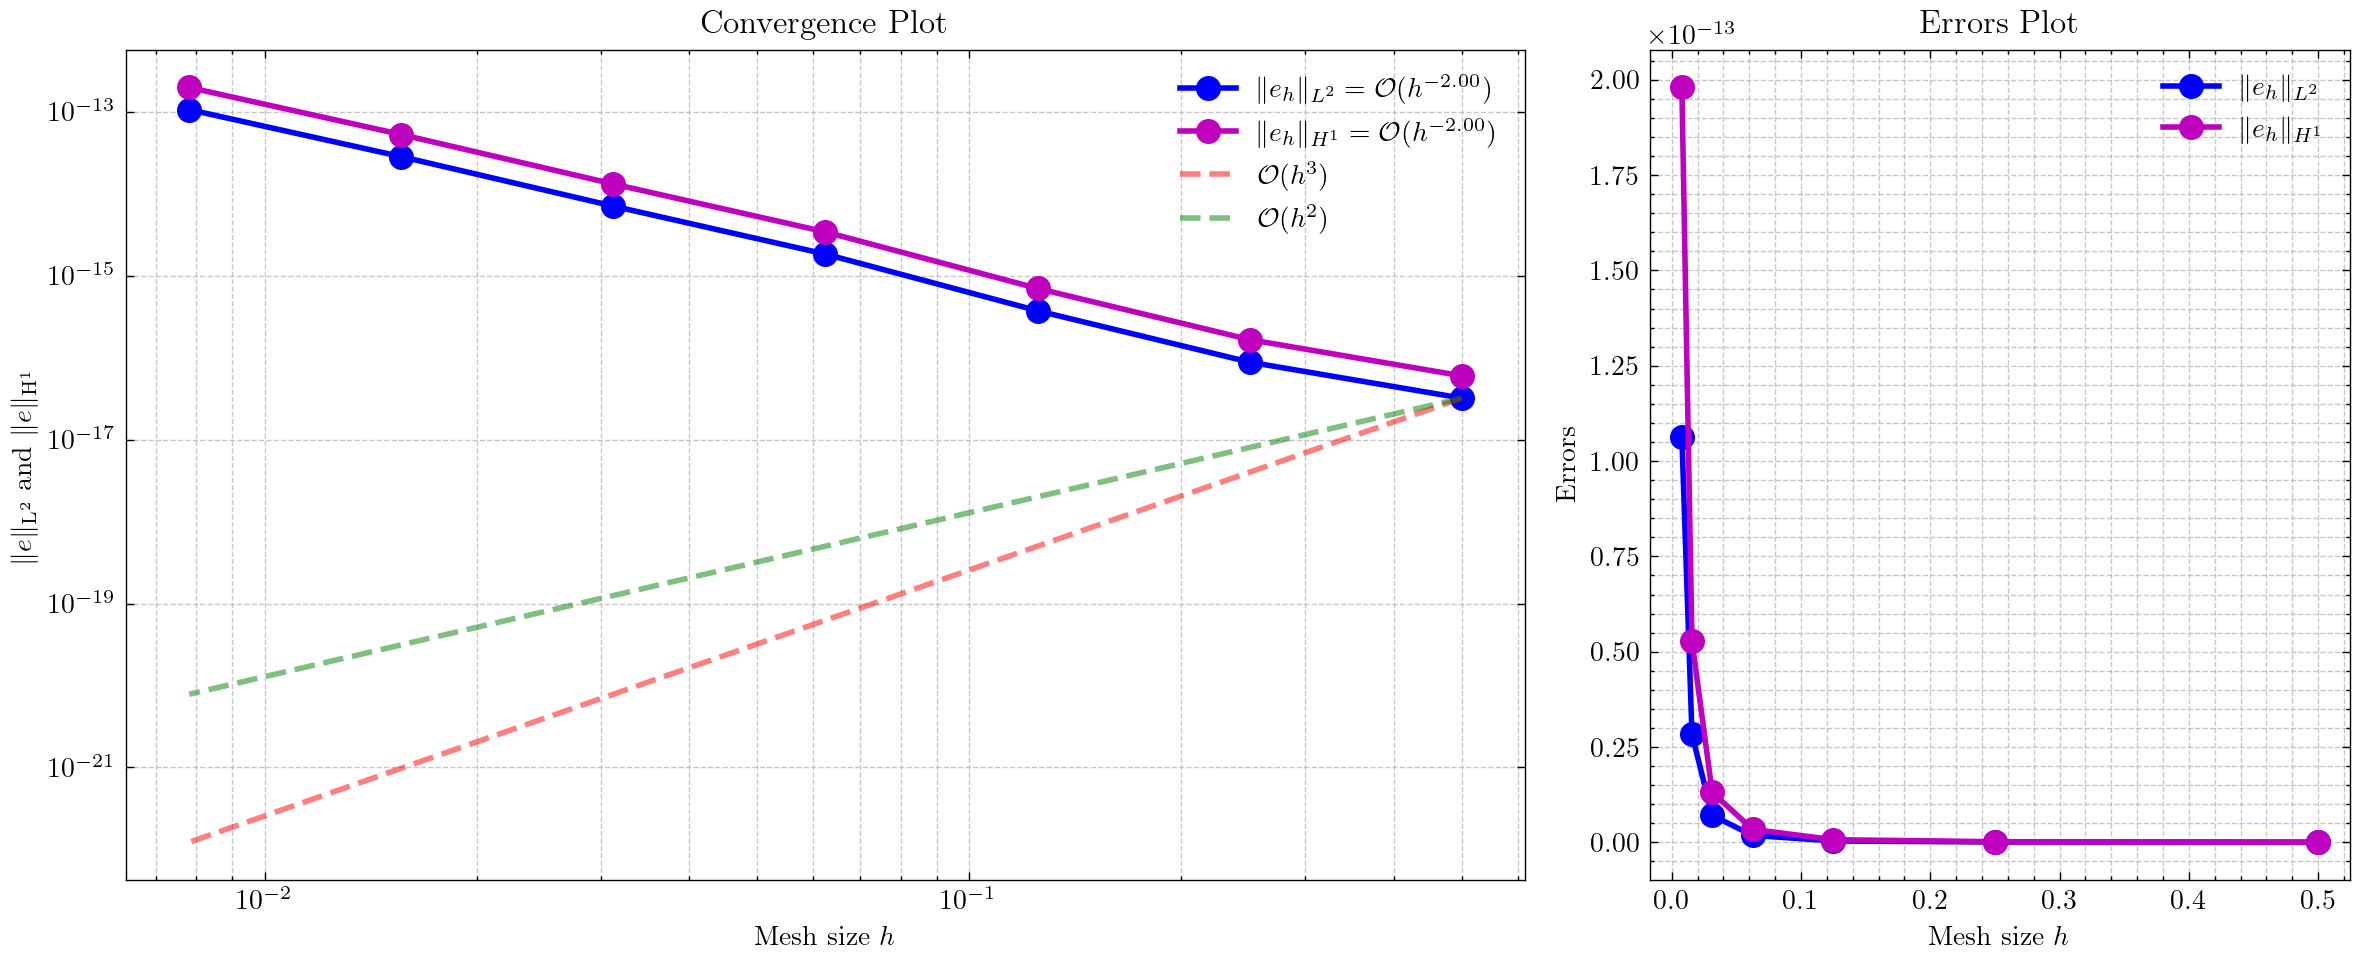

In [3]:
f1 = lambda x: 1.0
exact1 = lambda x: x*(1-x)/2

savefig = False
solver1 = FEMPoissonSolver(M=20, f=f1, exact=exact1)
solver1.assemble()
solver1.solve()
solver1.print_convergence_table()
solver1.plot(fine_mesh=200, name='simple', savefig=savefig)
solver1.plot_solution(name='simple', savefig=savefig)
solver1.plot_convergence(name='simple', savefig=savefig)

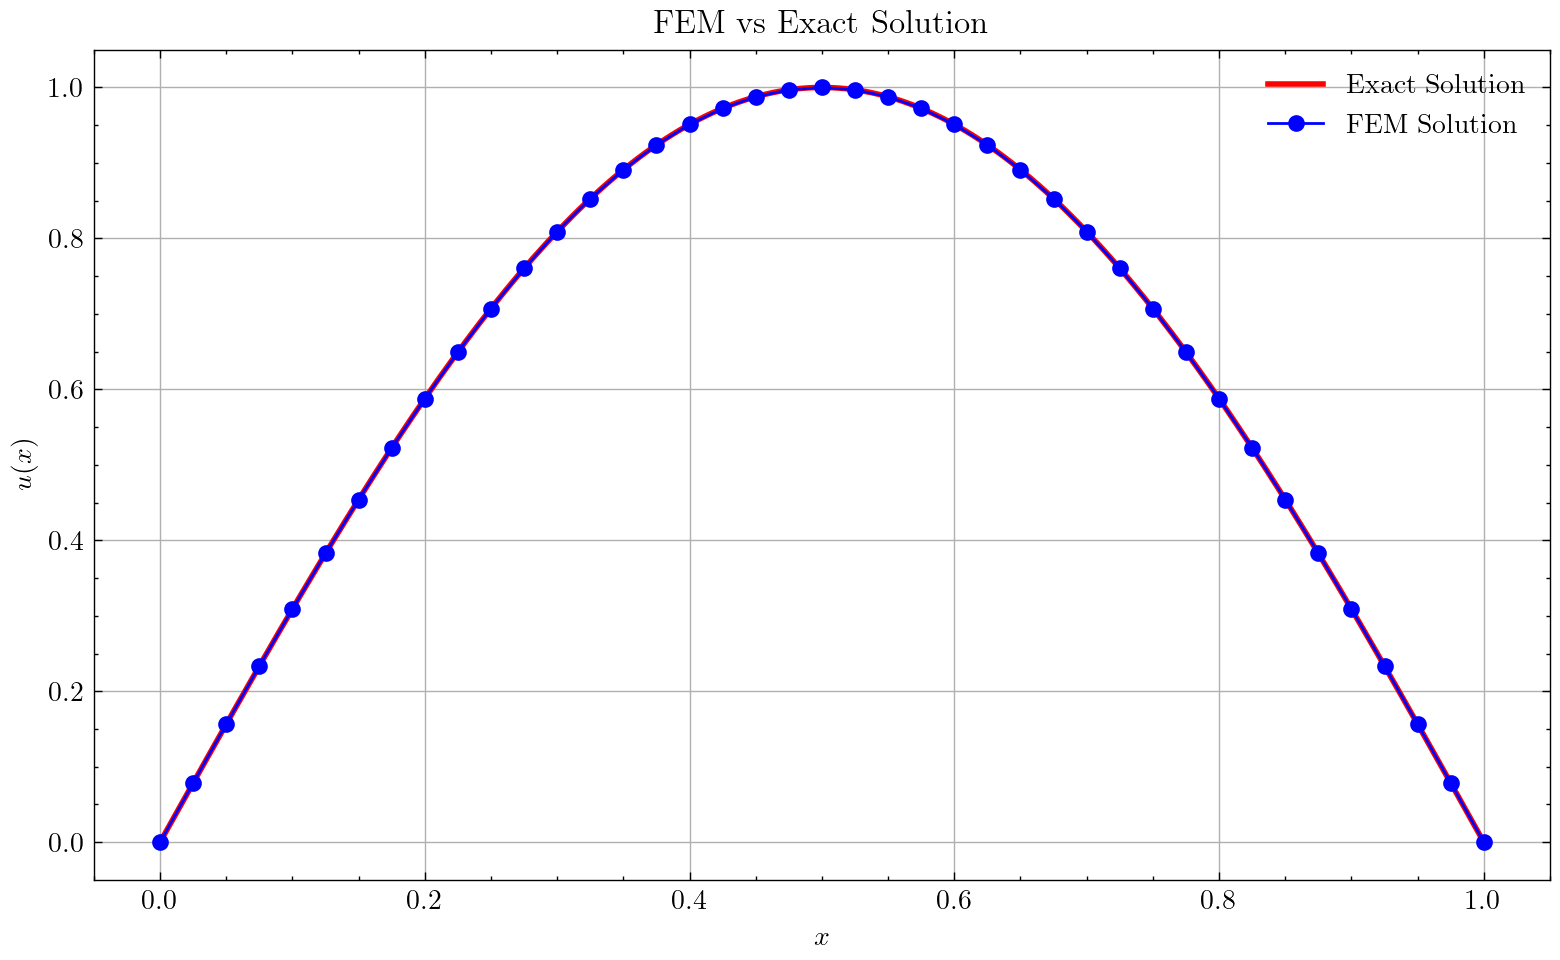

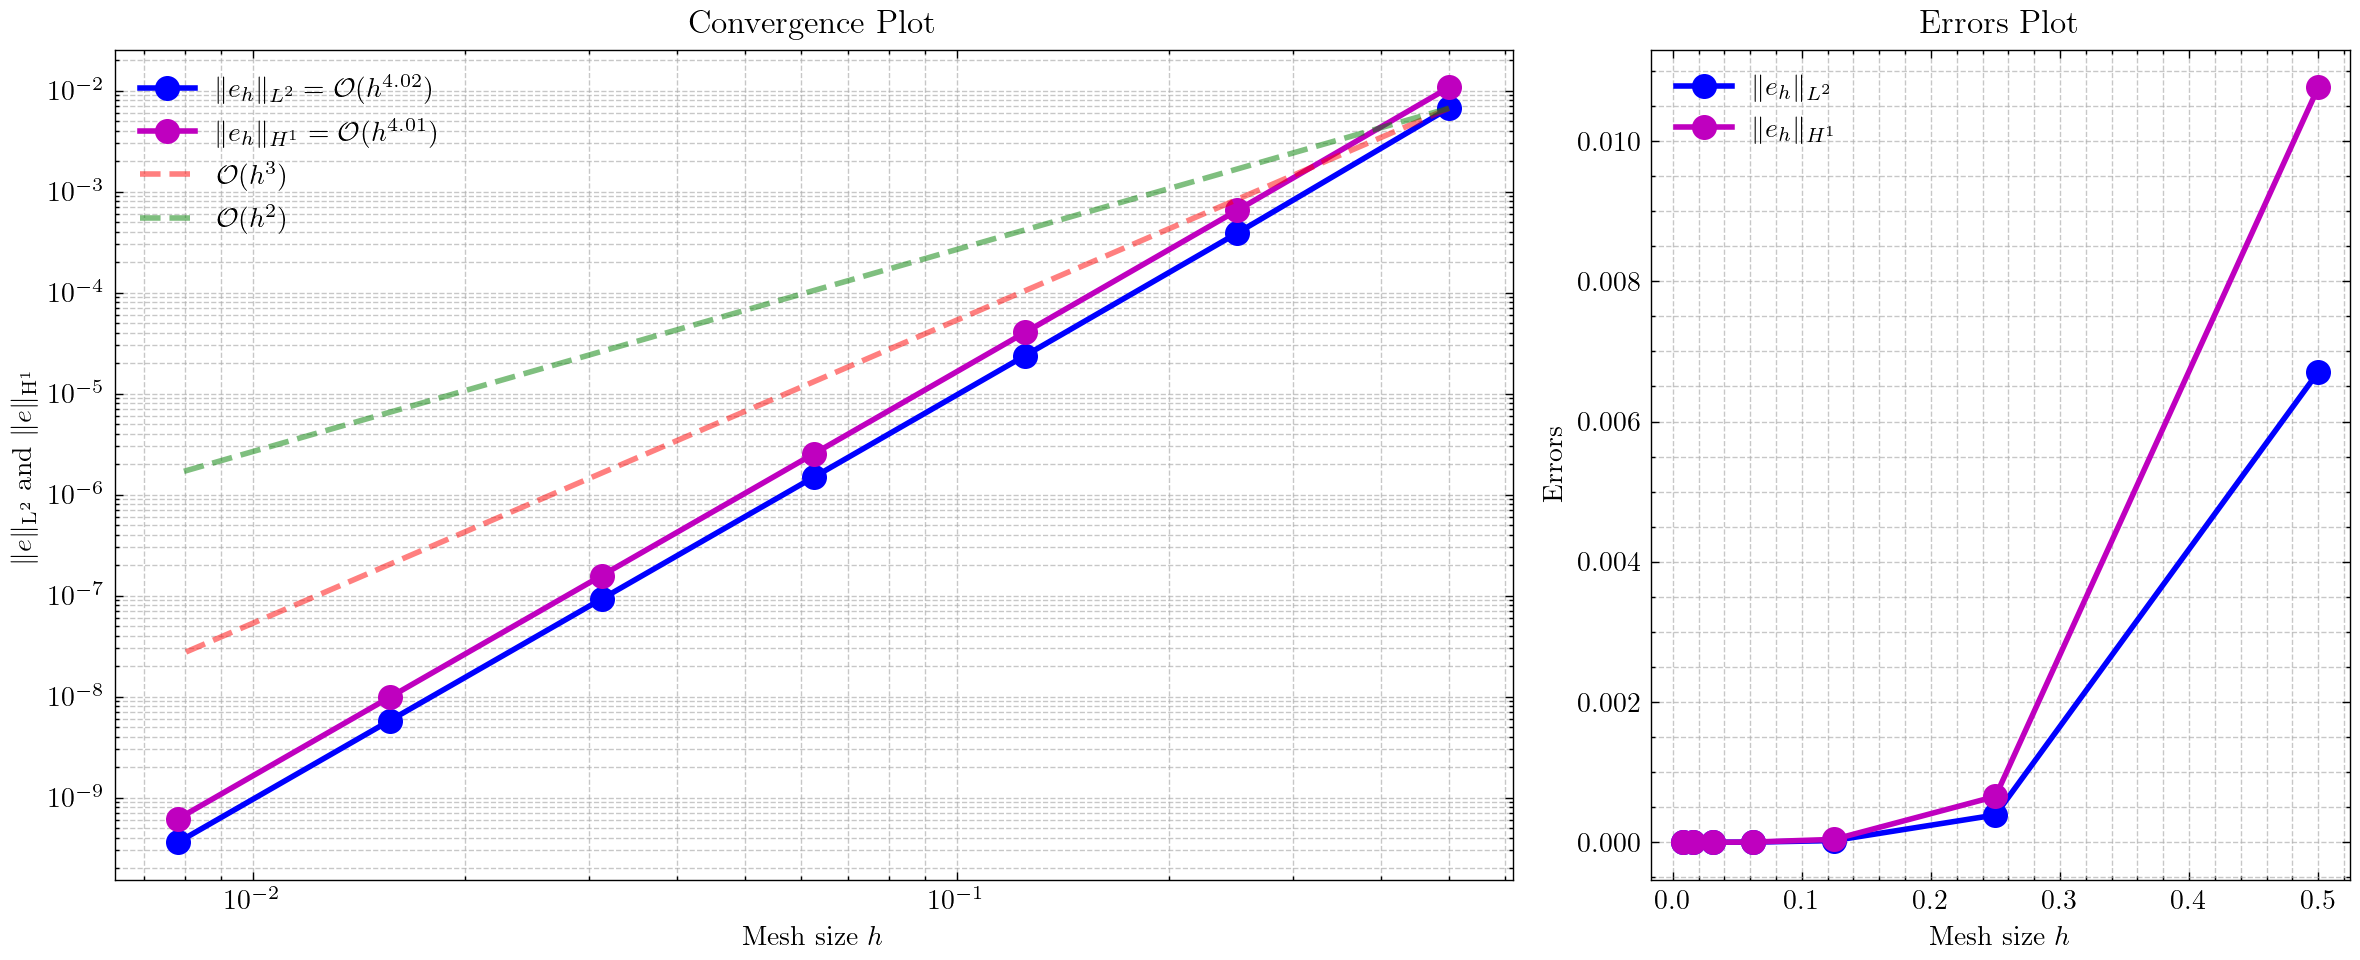


                              Convergence Analysis                              
    M         h      L2 Error  Rate L2   Ratio L2  H1 Error  Rate H1   Ratio H1 
--------------------------------------------------------------------------------
    2      5.00e-01  6.71e-03     -         -      1.08e-02     -         -     
    4      2.50e-01  3.89e-04    4.11     17.25    6.53e-04    4.04     16.49   
    8      1.25e-01  2.39e-05    4.03     16.29    4.05e-05    4.01     16.11   
    16     6.25e-02  1.48e-06    4.01     16.07    2.53e-06    4.00     16.03   
    32     3.12e-02  9.27e-08    4.00     16.02    1.58e-07    4.00     16.01   
    64     1.56e-02  5.79e-09    4.00     16.00    9.87e-09    4.00     16.00   
   128     7.81e-03  3.62e-10    4.00     16.02    6.17e-10    4.00     16.00   
Overall convergence rates - L2: 4.02, H1: 4.01
Final errors - L2: 3.62e-10, H1: 6.17e-10



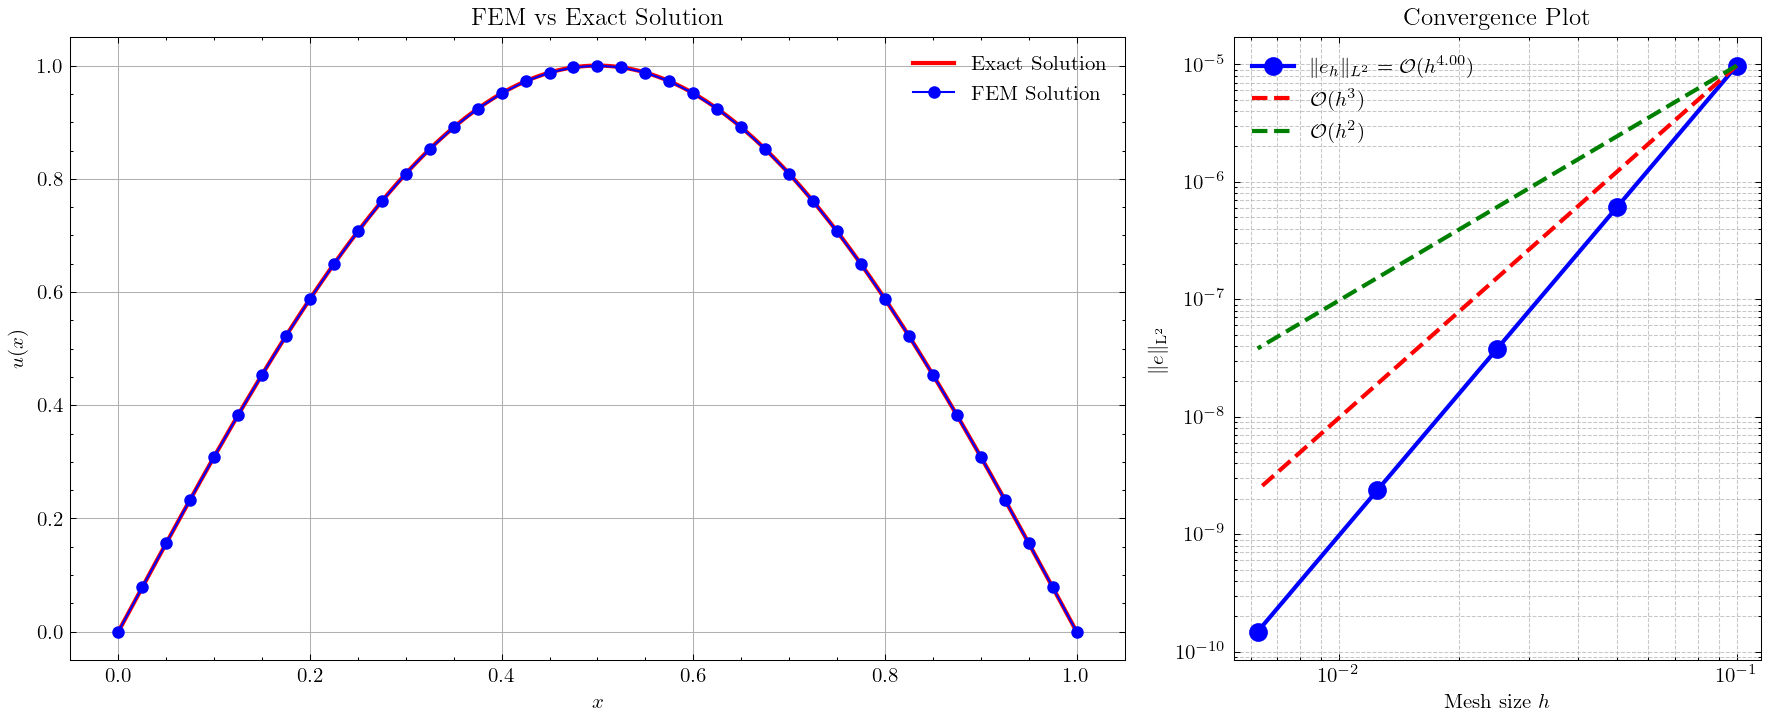

In [4]:

f2 = lambda x: np.pi**2 * np.sin(np.pi*x)
exact2 = lambda x: np.sin(np.pi*x)

savefig2= False
solver2 = FEMPoissonSolver(M=20, f=f2, exact=exact2)
solver2.assemble()
solver2.solve()
solver2.plot_solution(name='sine', savefig=savefig2)
solver2.plot_convergence(name='sine', savefig=savefig2)
solver2.print_convergence_table()
solver2.plot(fine_mesh=200, name='sine', savefig=savefig2)


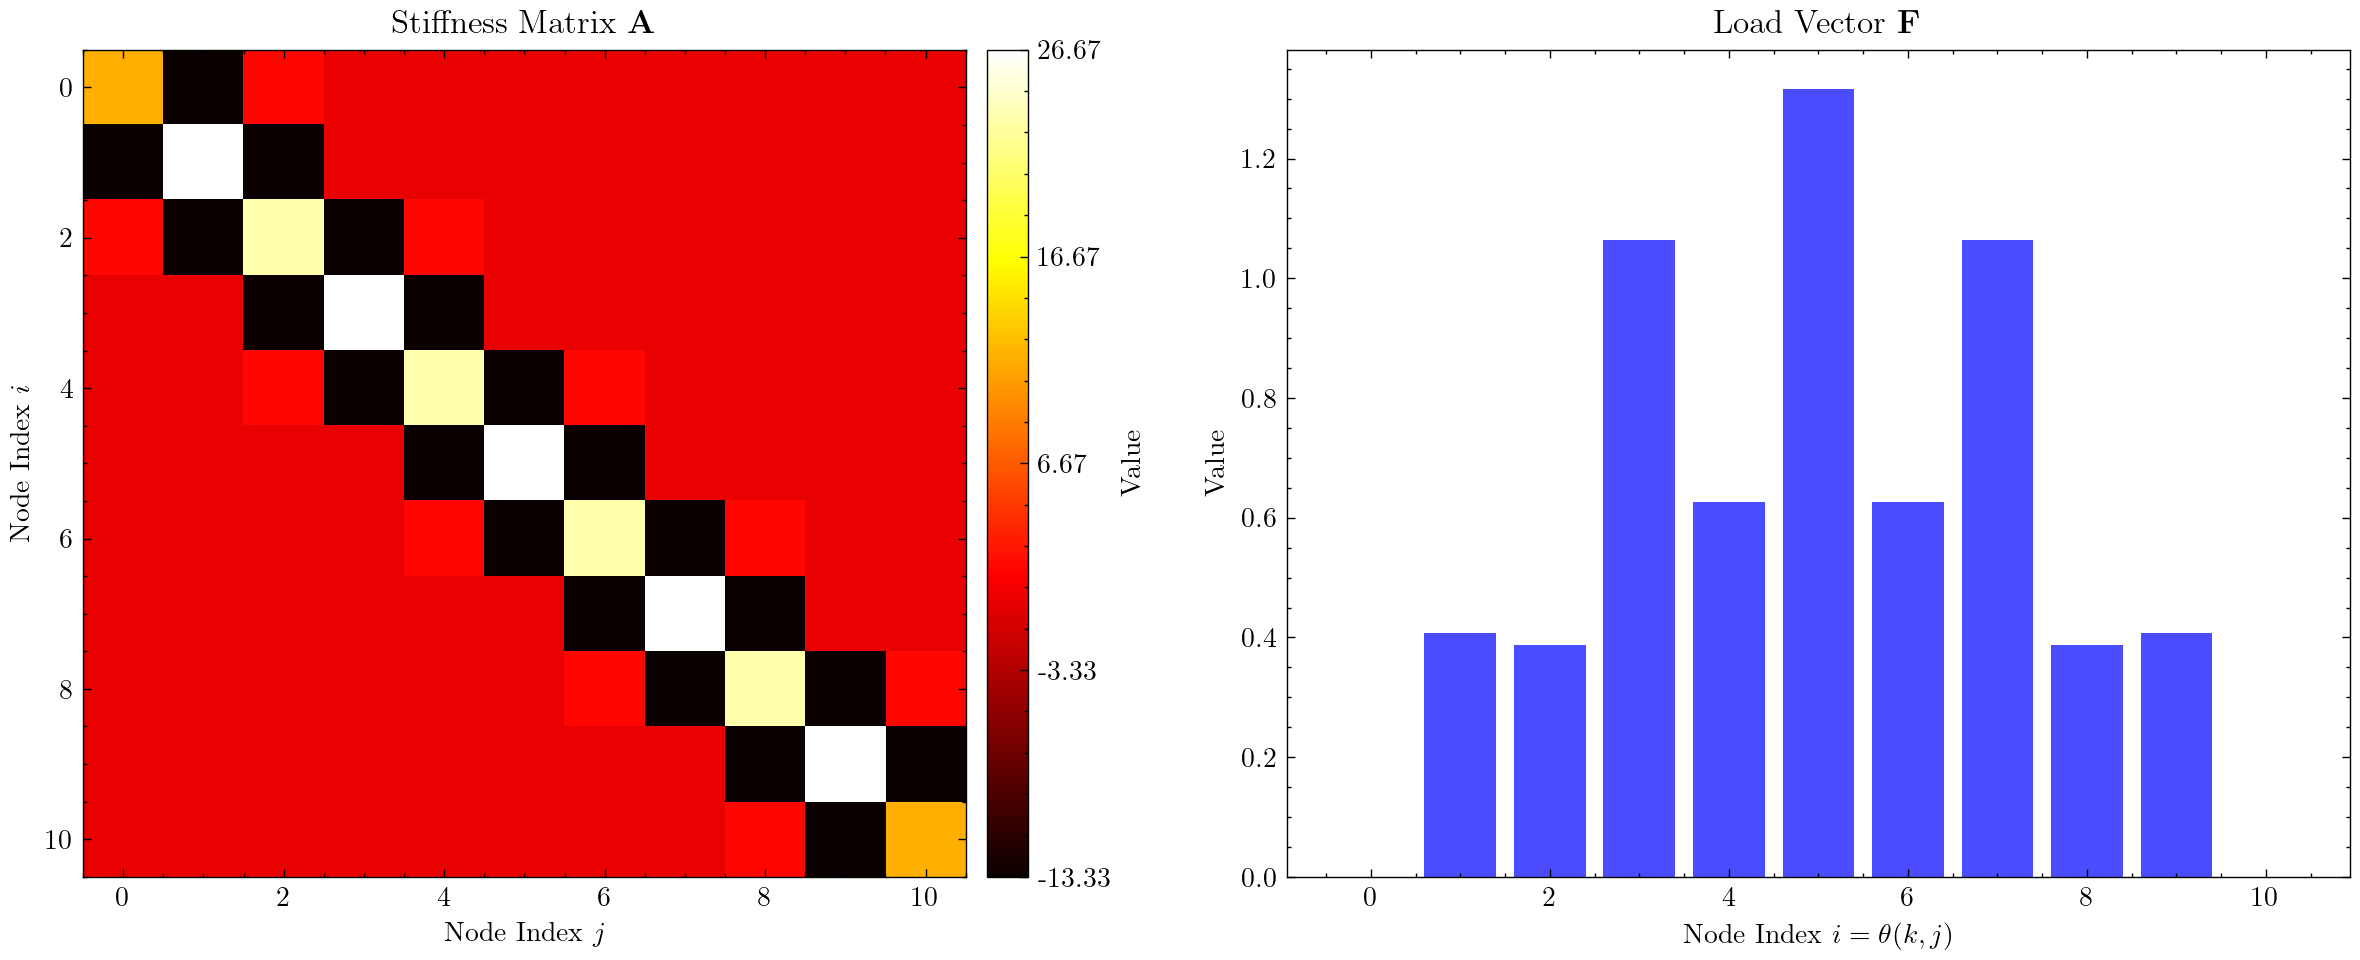

In [5]:
solver2 = FEMPoissonSolver(M=5, f=f2, exact=exact2)
solver2.assemble()
solver2.solve()
solver2.plot_stiffness_matrix_and_load_vector(name='sine', savefig= not savefig2)

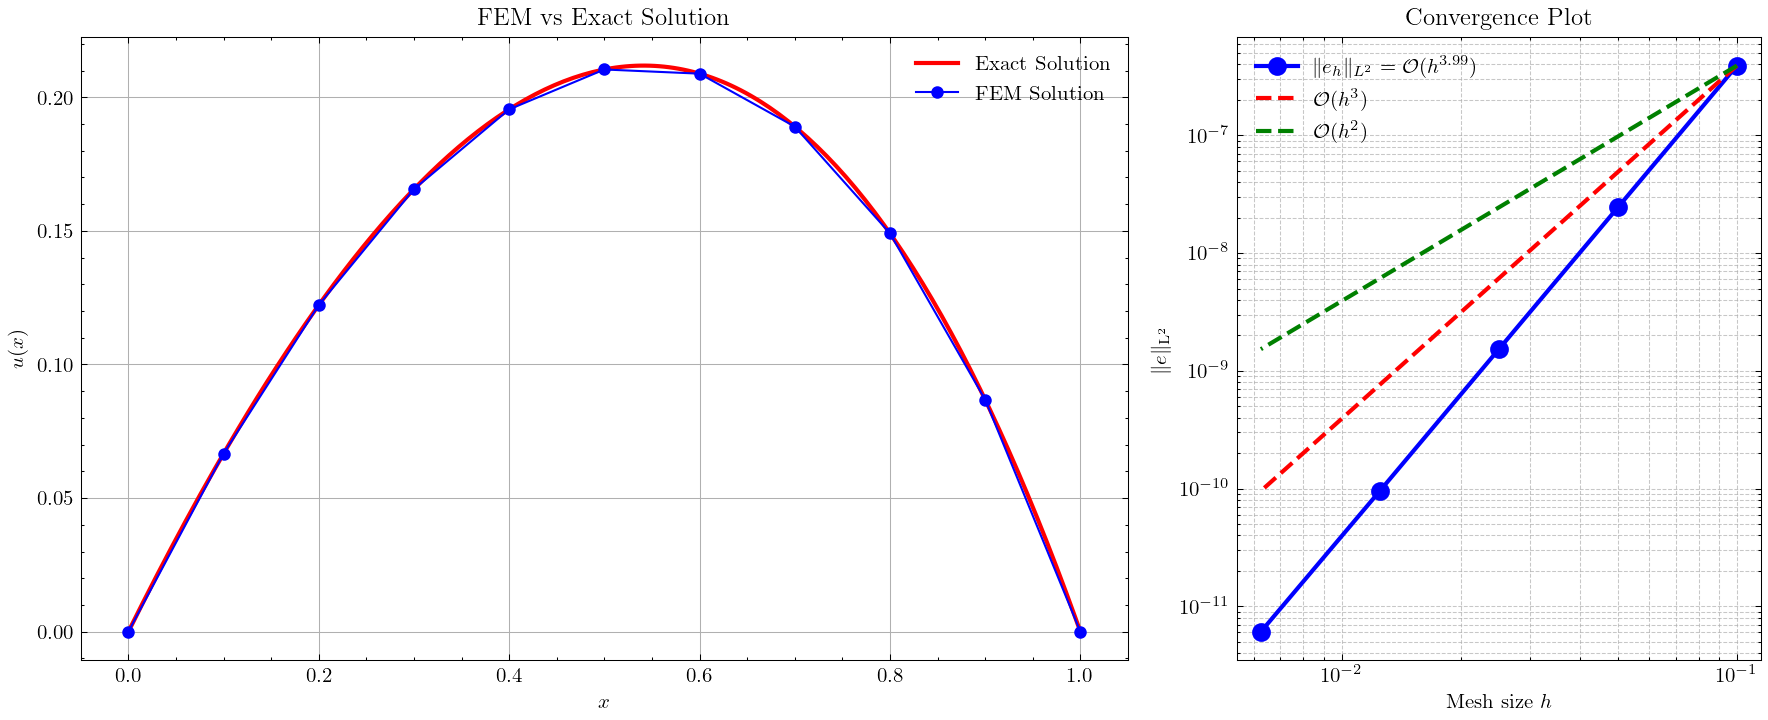

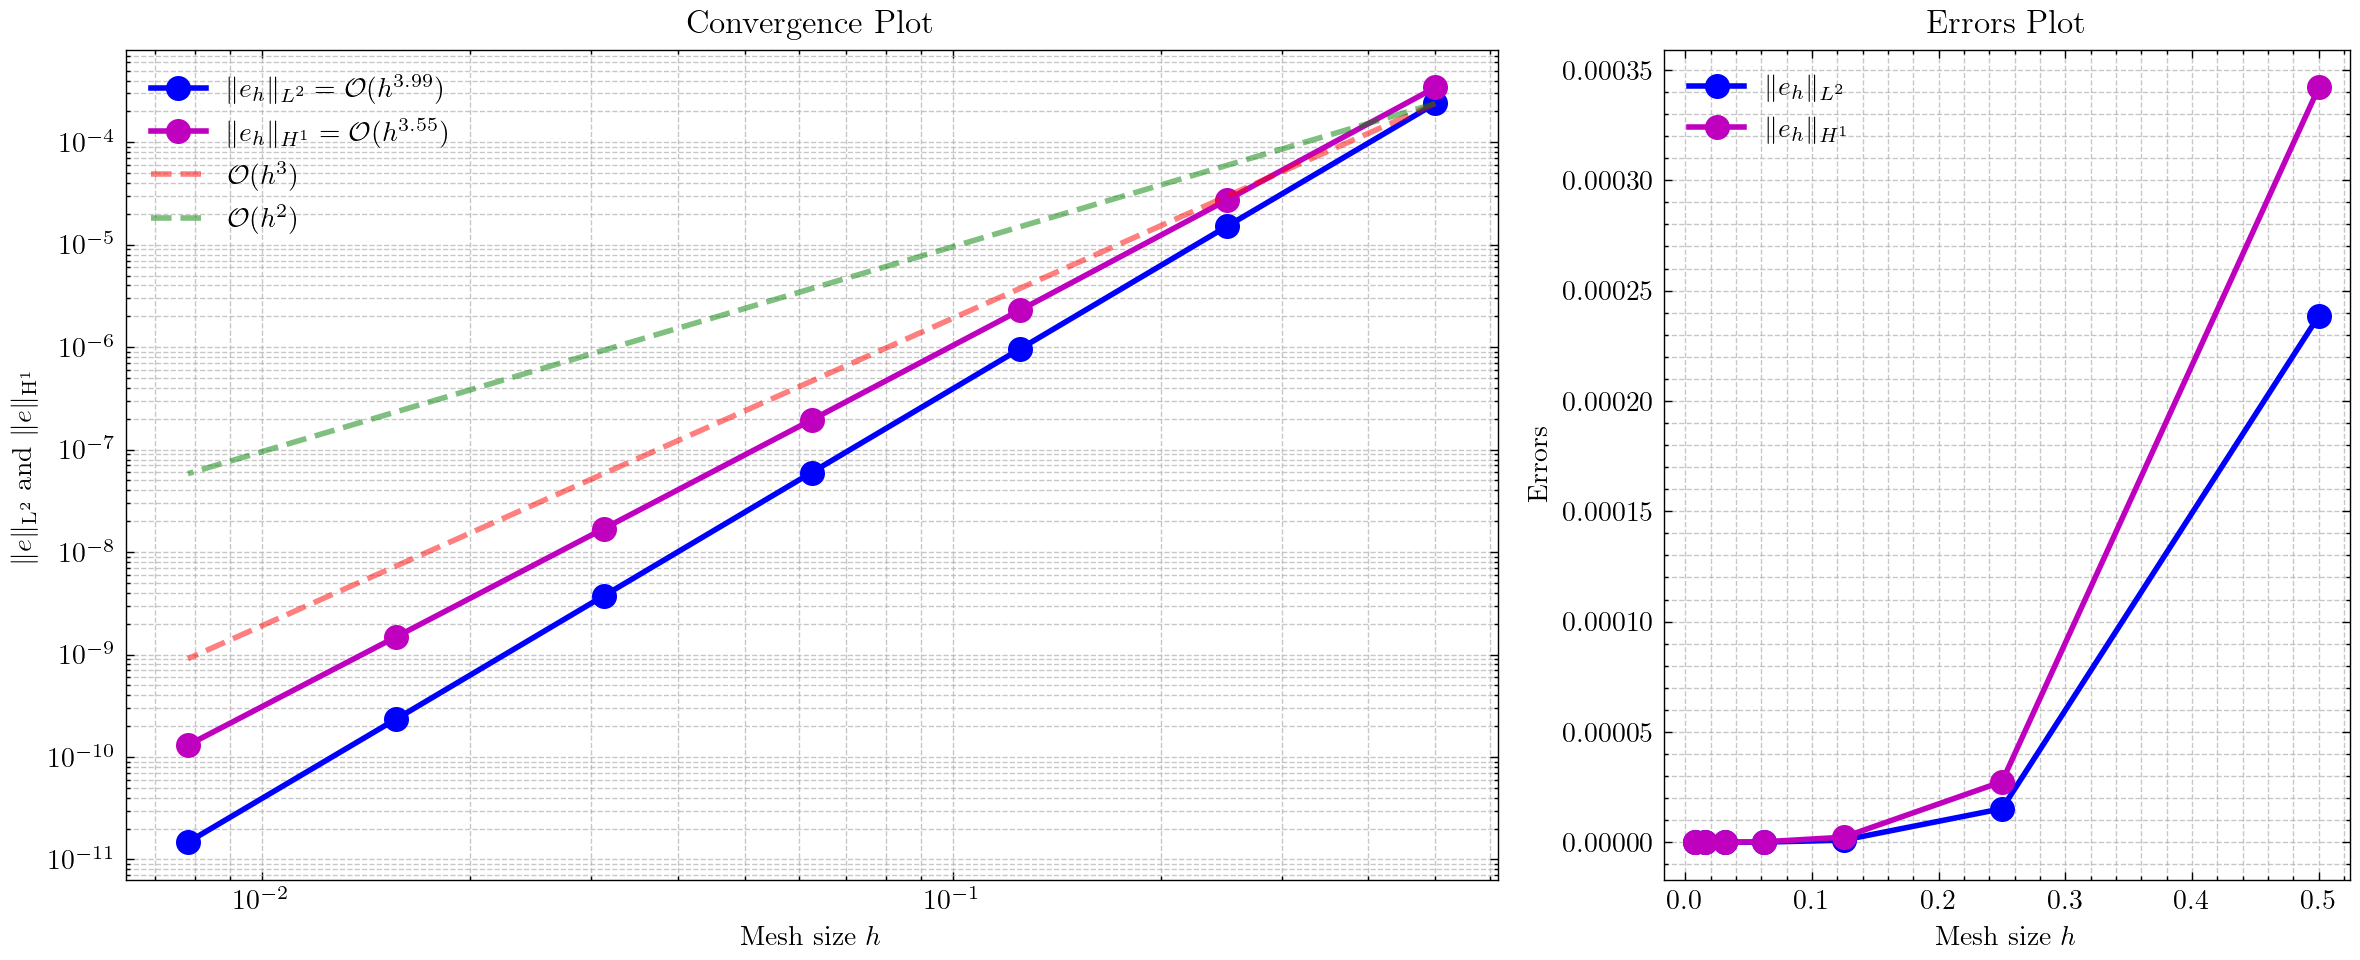


                              Convergence Analysis                              
    M         h      L2 Error  Rate L2   Ratio L2  H1 Error  Rate H1   Ratio H1 
--------------------------------------------------------------------------------
    2      5.00e-01  2.39e-04     -         -      3.42e-04     -         -     
    4      2.50e-01  1.52e-05    3.97     15.69    2.74e-05    3.64     12.47   
    8      1.25e-01  9.55e-07    3.99     15.92    2.28e-06    3.59     12.03   
    16     6.25e-02  5.97e-08    4.00     15.98    1.95e-07    3.55     11.70   
    32     3.12e-02  3.74e-09    4.00     16.00    1.69e-08    3.53     11.52   
    64     1.56e-02  2.34e-10    4.00     16.00    1.48e-09    3.51     11.42   
   128     7.81e-03  1.47e-11    3.99     15.86    1.30e-10    3.51     11.36   
Overall convergence rates - L2: 3.99, H1: 3.55
Final errors - L2: 1.47e-11, H1: 1.30e-10



In [6]:
def f_test3(x): return np.exp(x)
def u_exact_test3(x): return -np.exp(x) + (np.e - 1)*x + 1
savefig3 = False
solver3 = FEMPoissonSolver(M=5, f=f_test3, exact=u_exact_test3)
solver3.assemble()
solver3.solve()
solver3.plot(fine_mesh=200, name='exp', savefig=savefig3)
solver3.plot_convergence(name='exp', savefig=savefig3)
solver3.print_convergence_table()


                              Convergence Analysis                              
    M         h      L2 Error  Rate L2   Ratio L2  H1 Error  Rate H1   Ratio H1 
--------------------------------------------------------------------------------
    2      5.00e-01  4.88e-03     -         -      8.44e-03     -         -     
    4      2.50e-01  1.74e-04    4.81     27.99    4.64e-04    4.19     18.20   
    8      1.25e-01  1.01e-05    4.10     17.20    2.86e-05    4.02     16.20   
    16     6.25e-02  6.23e-07    4.03     16.28    1.78e-06    4.00     16.04   
    32     3.12e-02  3.88e-08    4.01     16.07    1.11e-07    4.00     16.01   
    64     1.56e-02  2.42e-09    4.00     16.02    6.97e-09    4.00     16.00   
   128     7.81e-03  1.51e-10    4.00     16.01    4.35e-10    4.00     16.00   
Overall convergence rates - L2: 4.11, H1: 4.02
Final errors - L2: 1.51e-10, H1: 4.35e-10



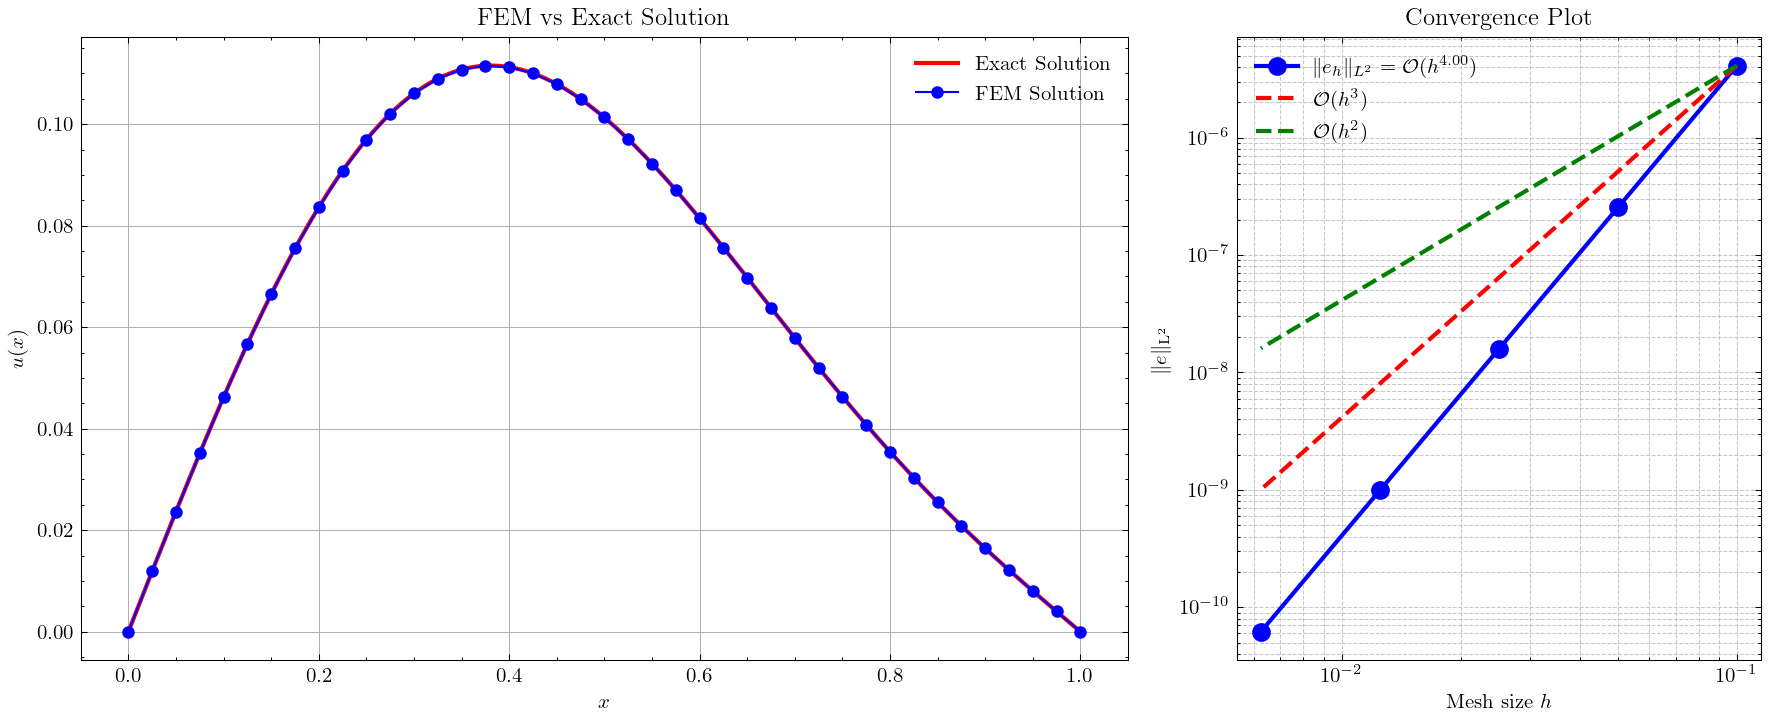

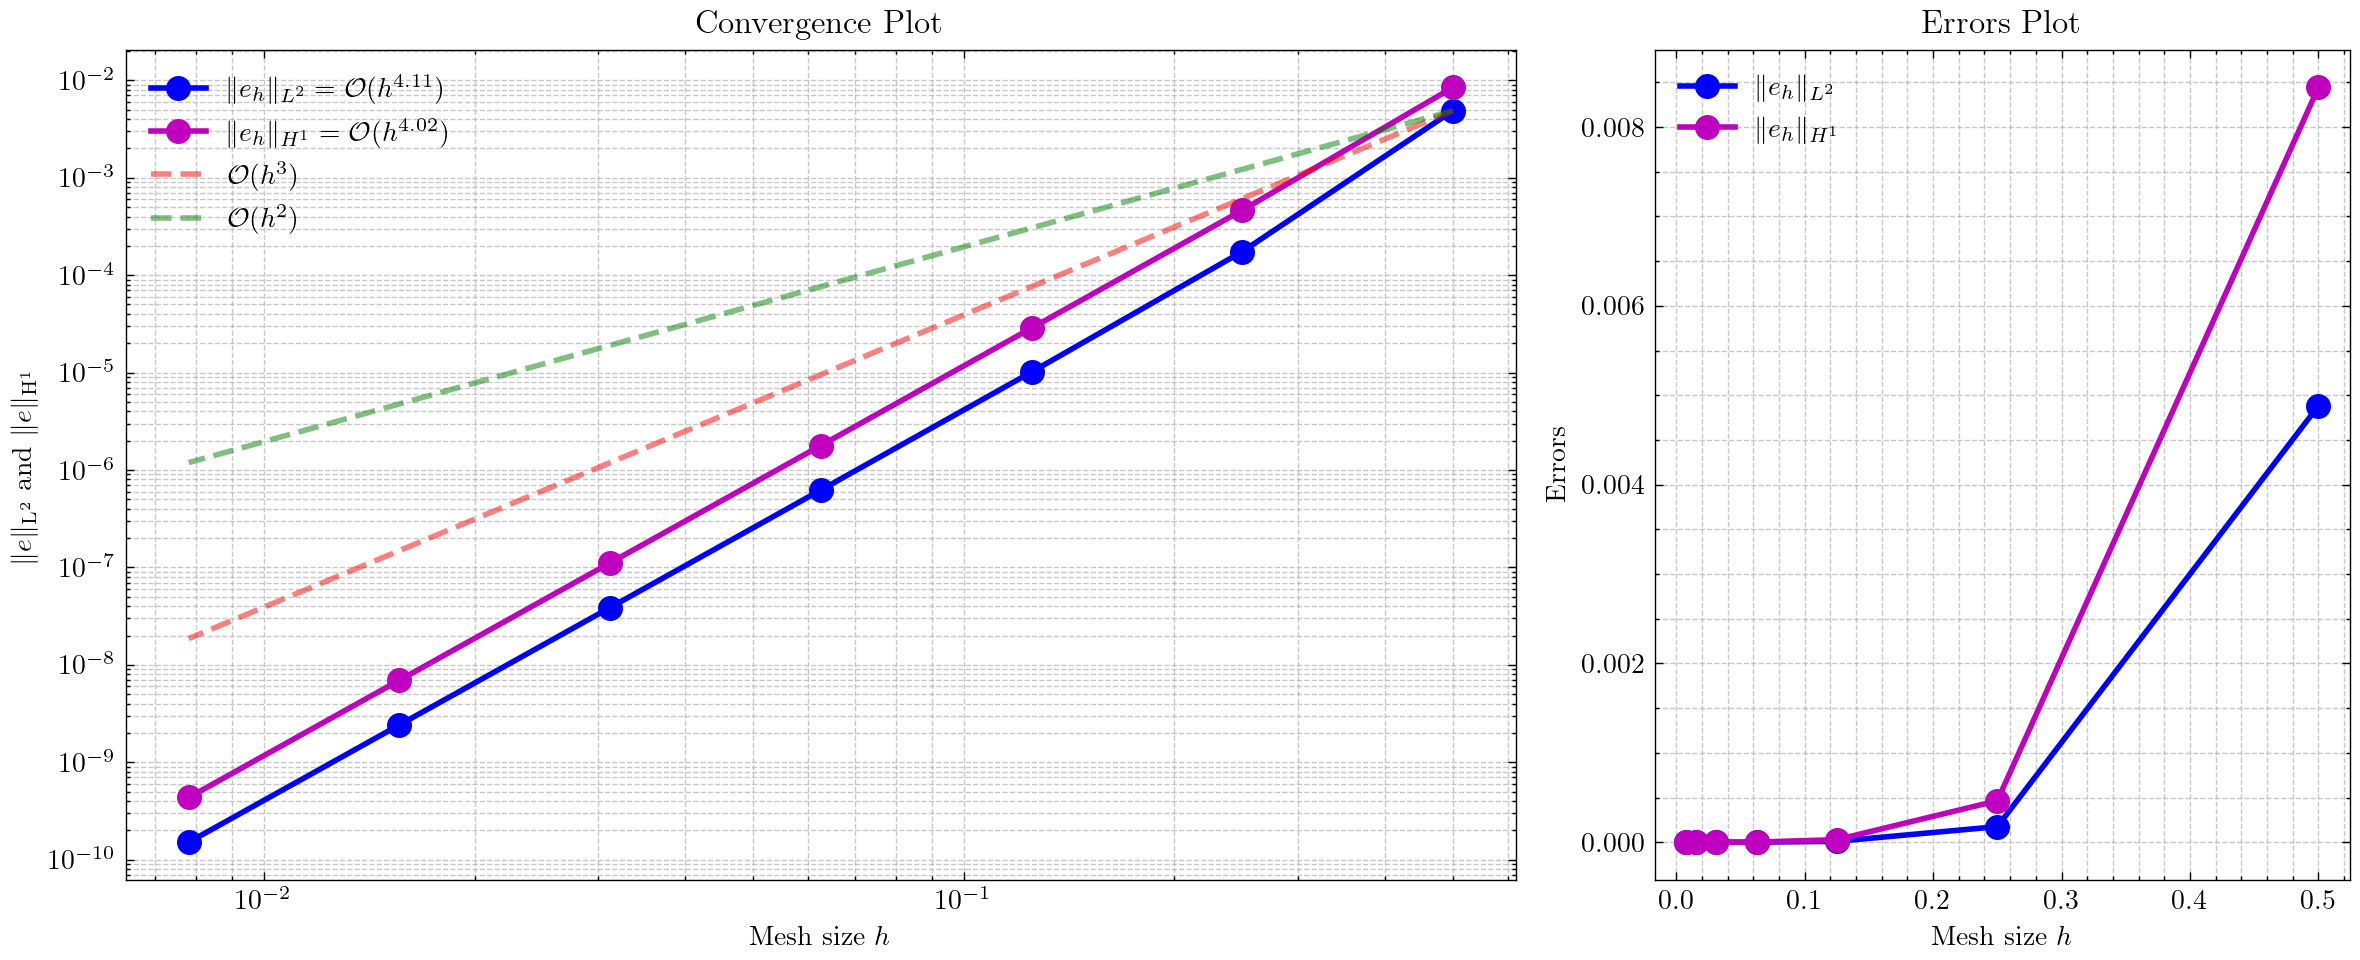

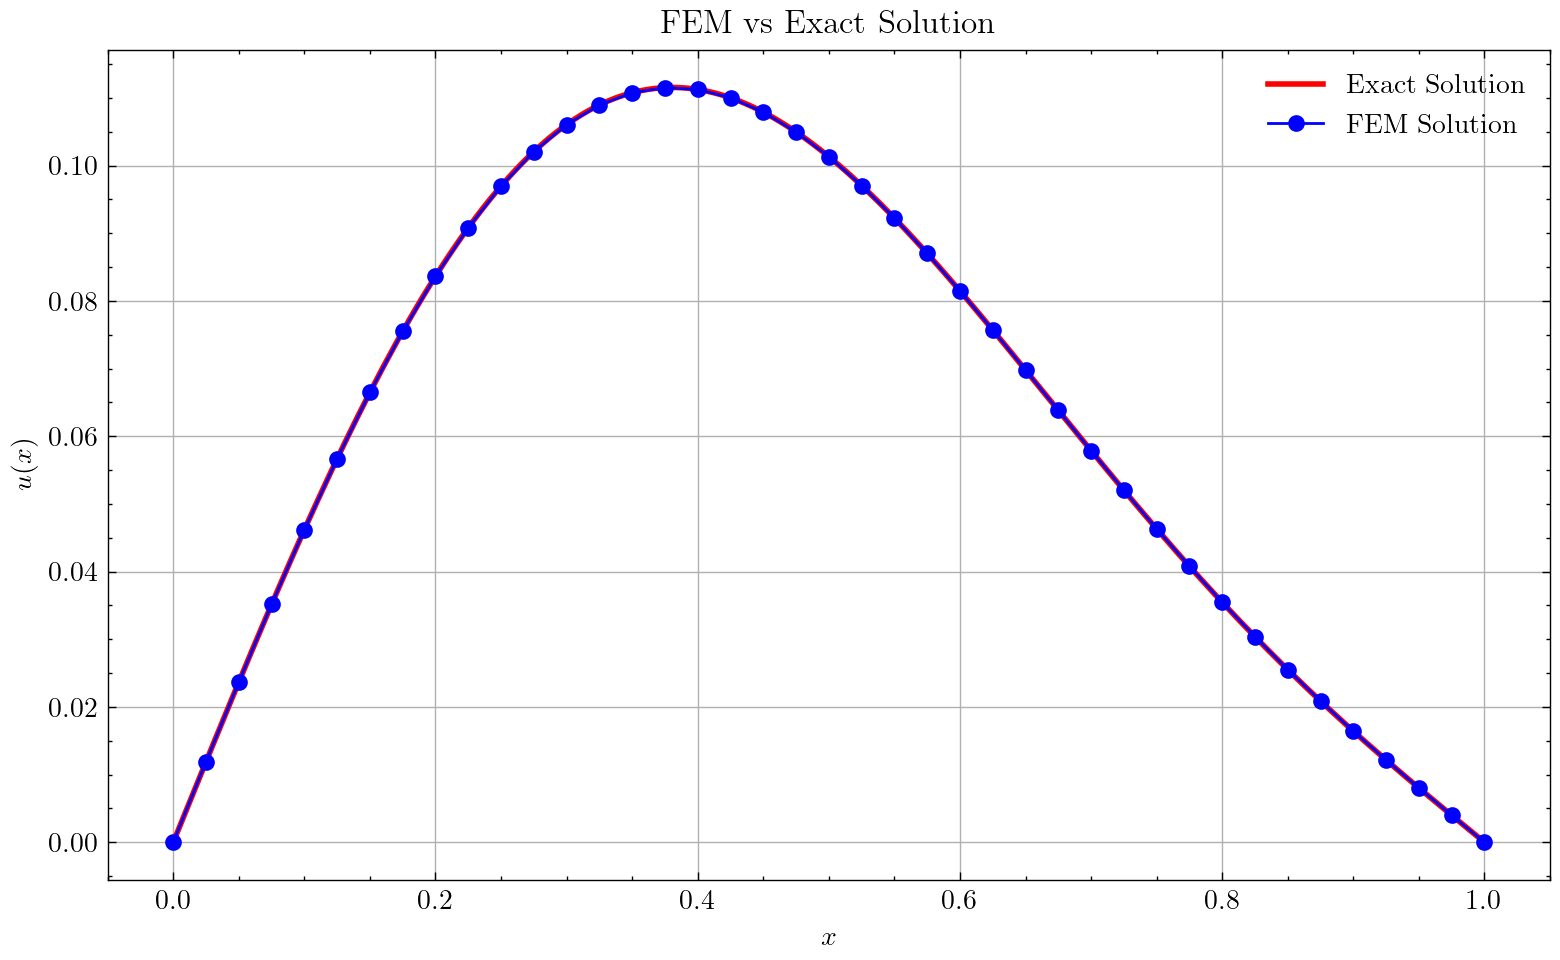

In [7]:

def u_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.sin(np.pi * x) + (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)
def f_test4(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)

savefig4 = False
solver4 = FEMPoissonSolver(M=20, f=f_test4, exact=u_exact_test4)
solver4.assemble()
solver4.solve()
solver4.print_convergence_table()
solver4.plot(fine_mesh=200, name='complex', savefig=savefig4)
solver4.plot_convergence(name='complex', savefig=savefig4)
solver4.plot_solution(name='complex', savefig=savefig4)

Convergence Table for yd_case1:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.006345        nan             nan             0.010392        nan             nan            
0.01       8          0.002499        1.344161        -2.881409       0.011326        -0.124173       -2.154724      
0.01       16         0.001064        1.232689        -2.469229       0.008266        0.454465        -1.729659      
0.01       32         0.000443        1.264415        -2.228266       0.005774        0.517517        -1.487231      
0.01       64         0.000185        1.255462        -2.066132       0.003827        0.593555        -1.338285      
0.01       128        0.000078        1.252804        -1.949942       0.002438        0.650127        -1.239976      
0.0001     4          0.000309        nan             nan             0.003475        nan             nan            
0.0001     8          0.

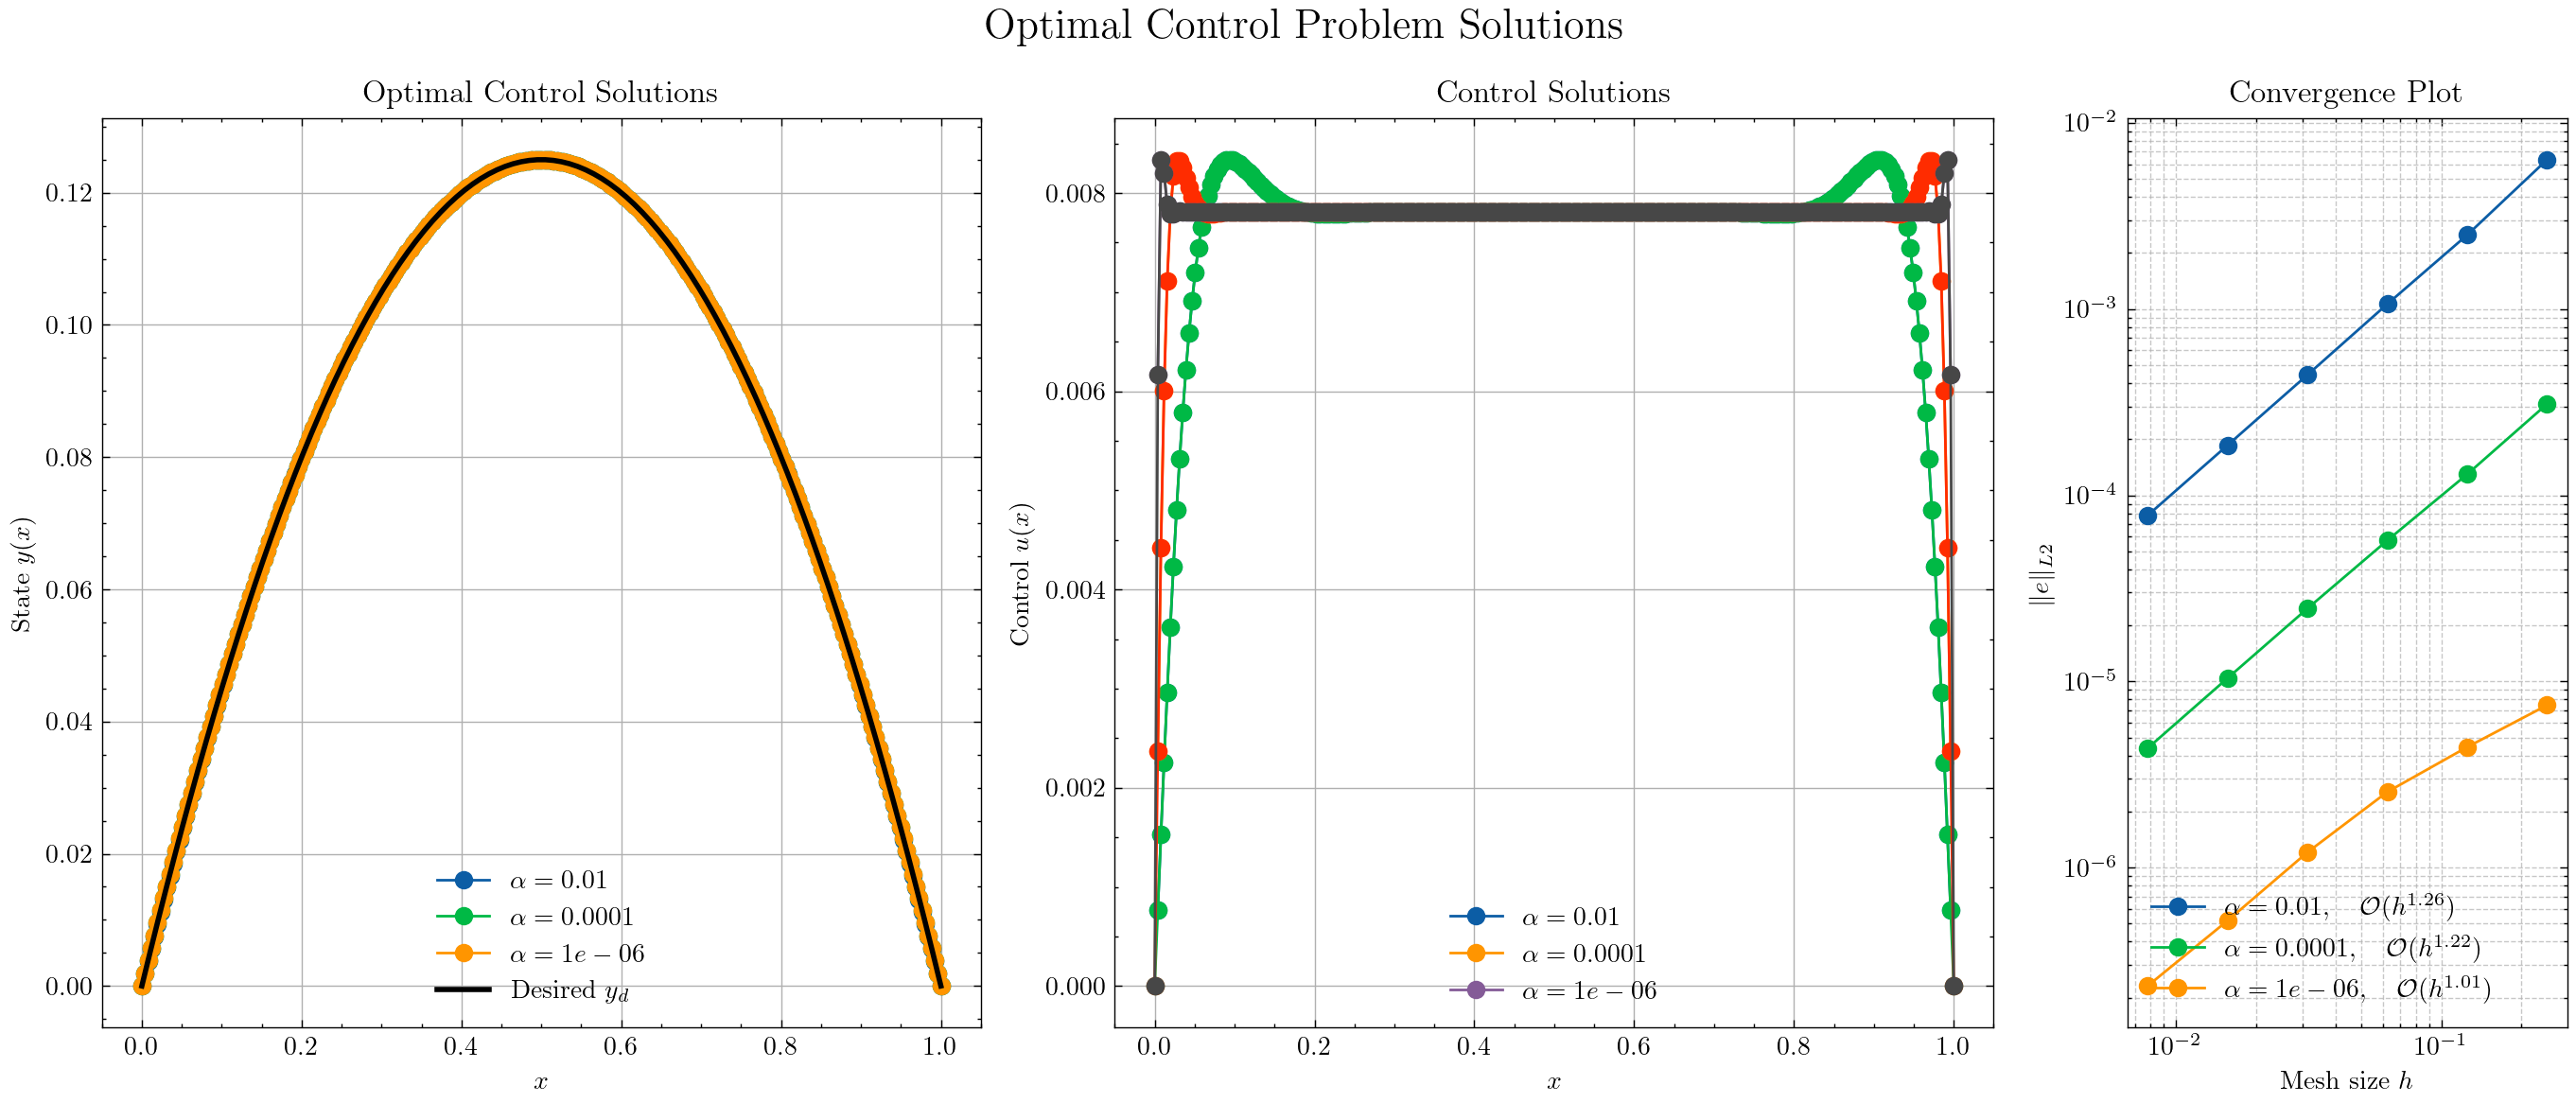



Convergence Table for yd_case2:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.270352        nan             nan             2.066545        nan             nan            
0.01       8          0.266085        0.022952        -0.636680       2.576473        -0.318176       0.455133       
0.01       16         0.239538        0.151631        -0.515418       3.272583        -0.345032       0.427607       
0.01       32         0.213174        0.168228        -0.445980       4.048530        -0.306968       0.403480       
0.01       64         0.186429        0.193402        -0.403883       4.931085        -0.284507       0.383651       
0.01       128        0.161157        0.210163        -0.376209       5.954926        -0.272178       0.367726       
0.0001     4          0.055638        nan             nan             0.671054        nan             nan            
0.0001     8          

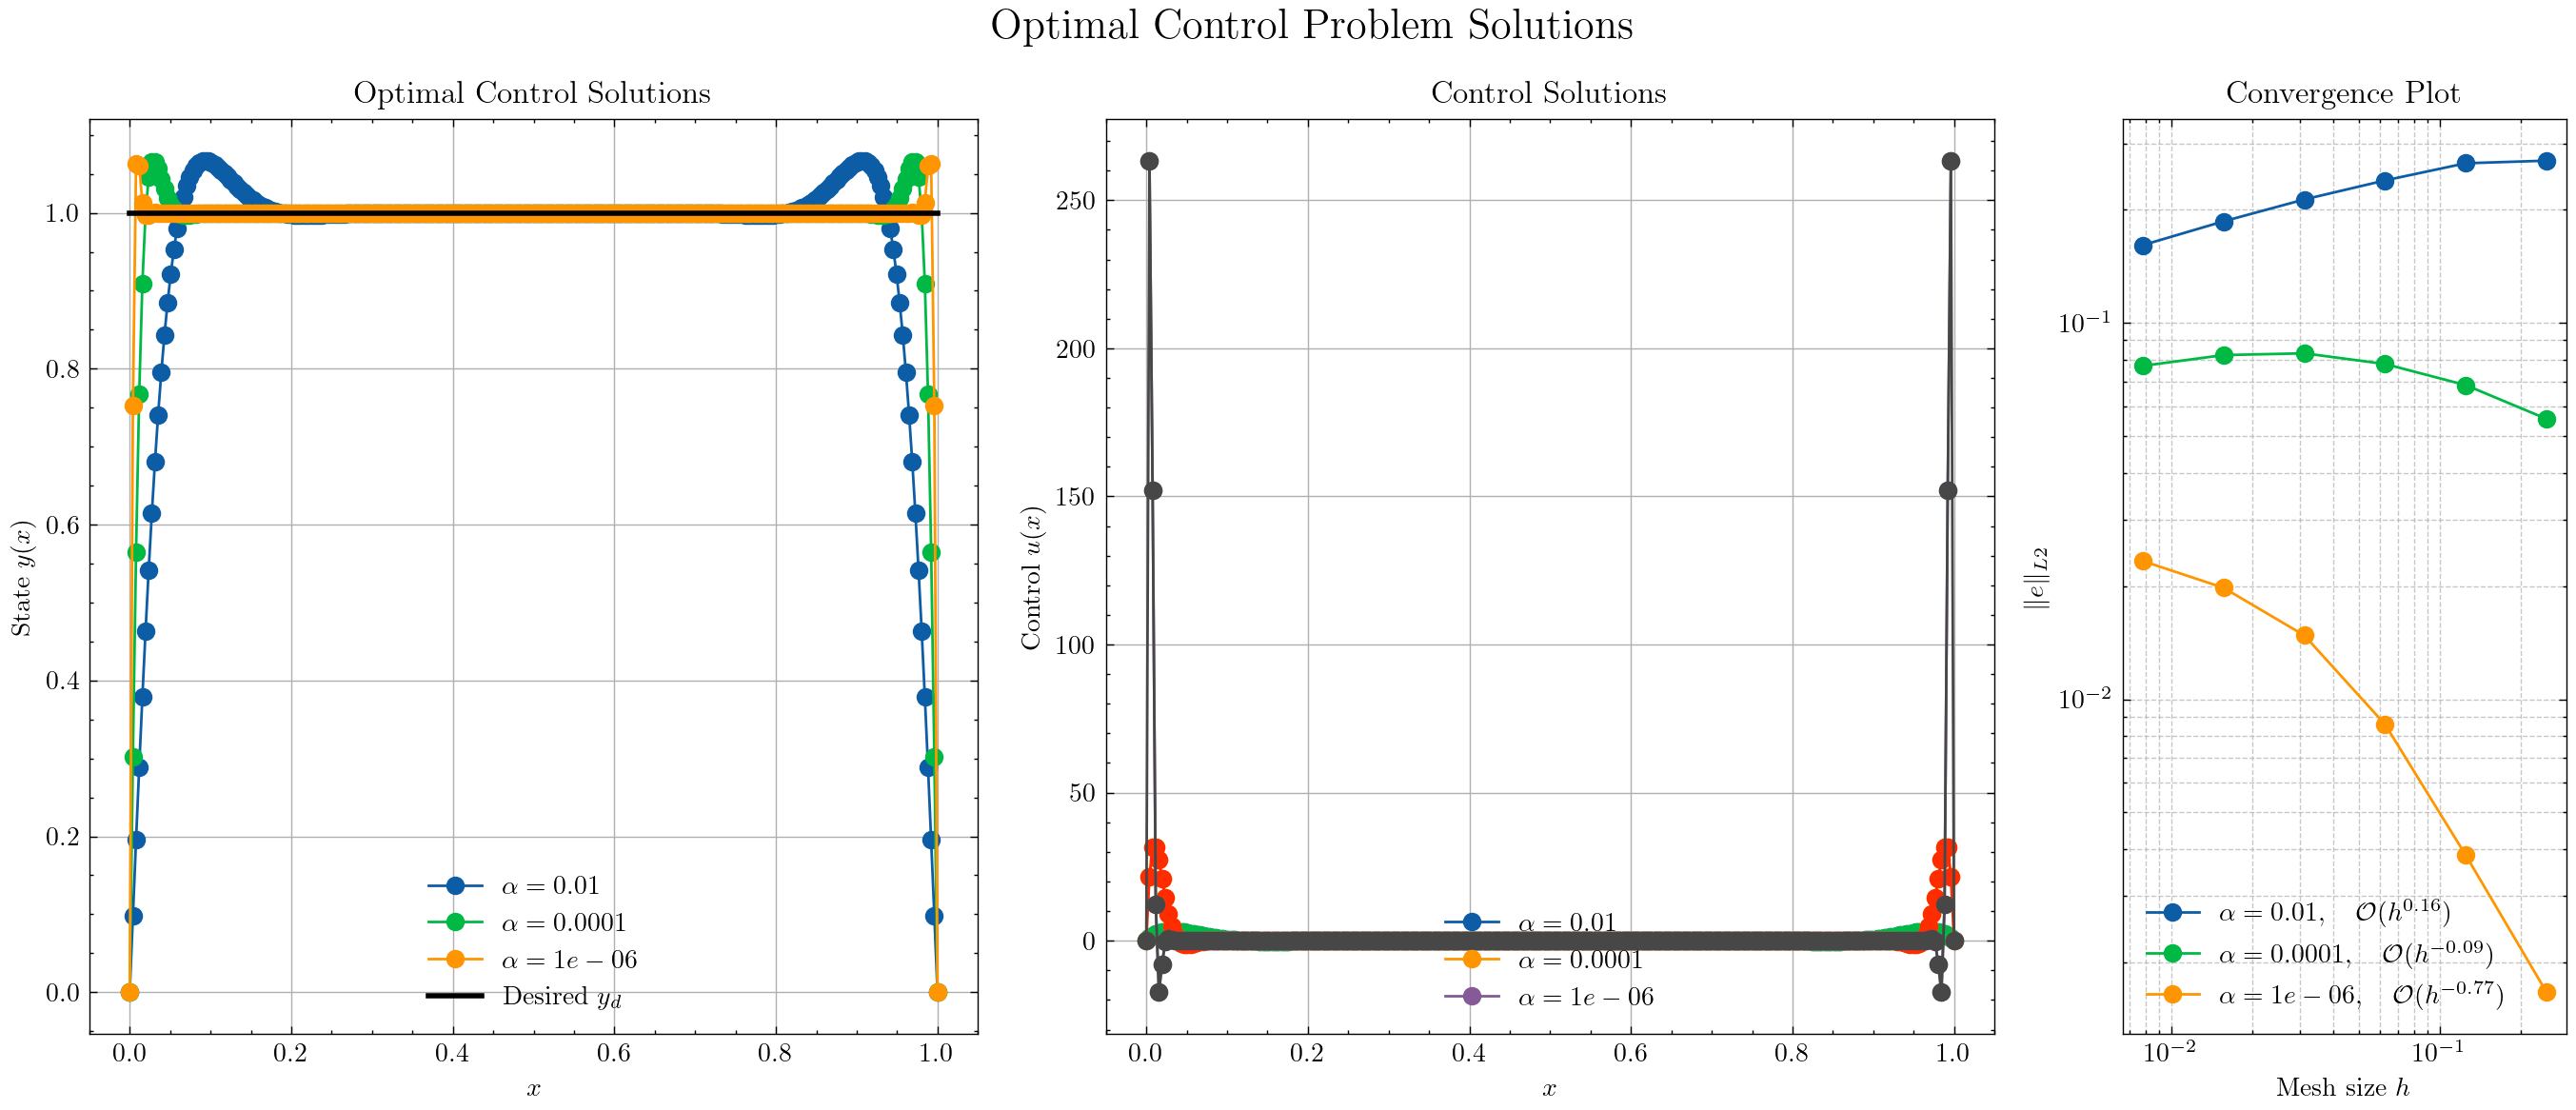



Convergence Table for yd_case3:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.260253        nan             nan             3.115391        nan             nan            
0.01       8          0.244090        0.092502        -0.678172       3.092364        0.010703        0.542903       
0.01       16         0.207382        0.235117        -0.567409       4.708724        -0.606626       0.558834       
0.01       32         0.172798        0.263207        -0.506568       7.025900        -0.577347       0.562537       
0.01       64         0.145044        0.252600        -0.464240       10.333750       -0.556609       0.561549       
0.01       128        0.121858        0.251290        -0.433819       15.016081       -0.539144       0.558348       
0.0001     4          0.122636        nan             nan             1.387773        nan             nan            
0.0001     8          

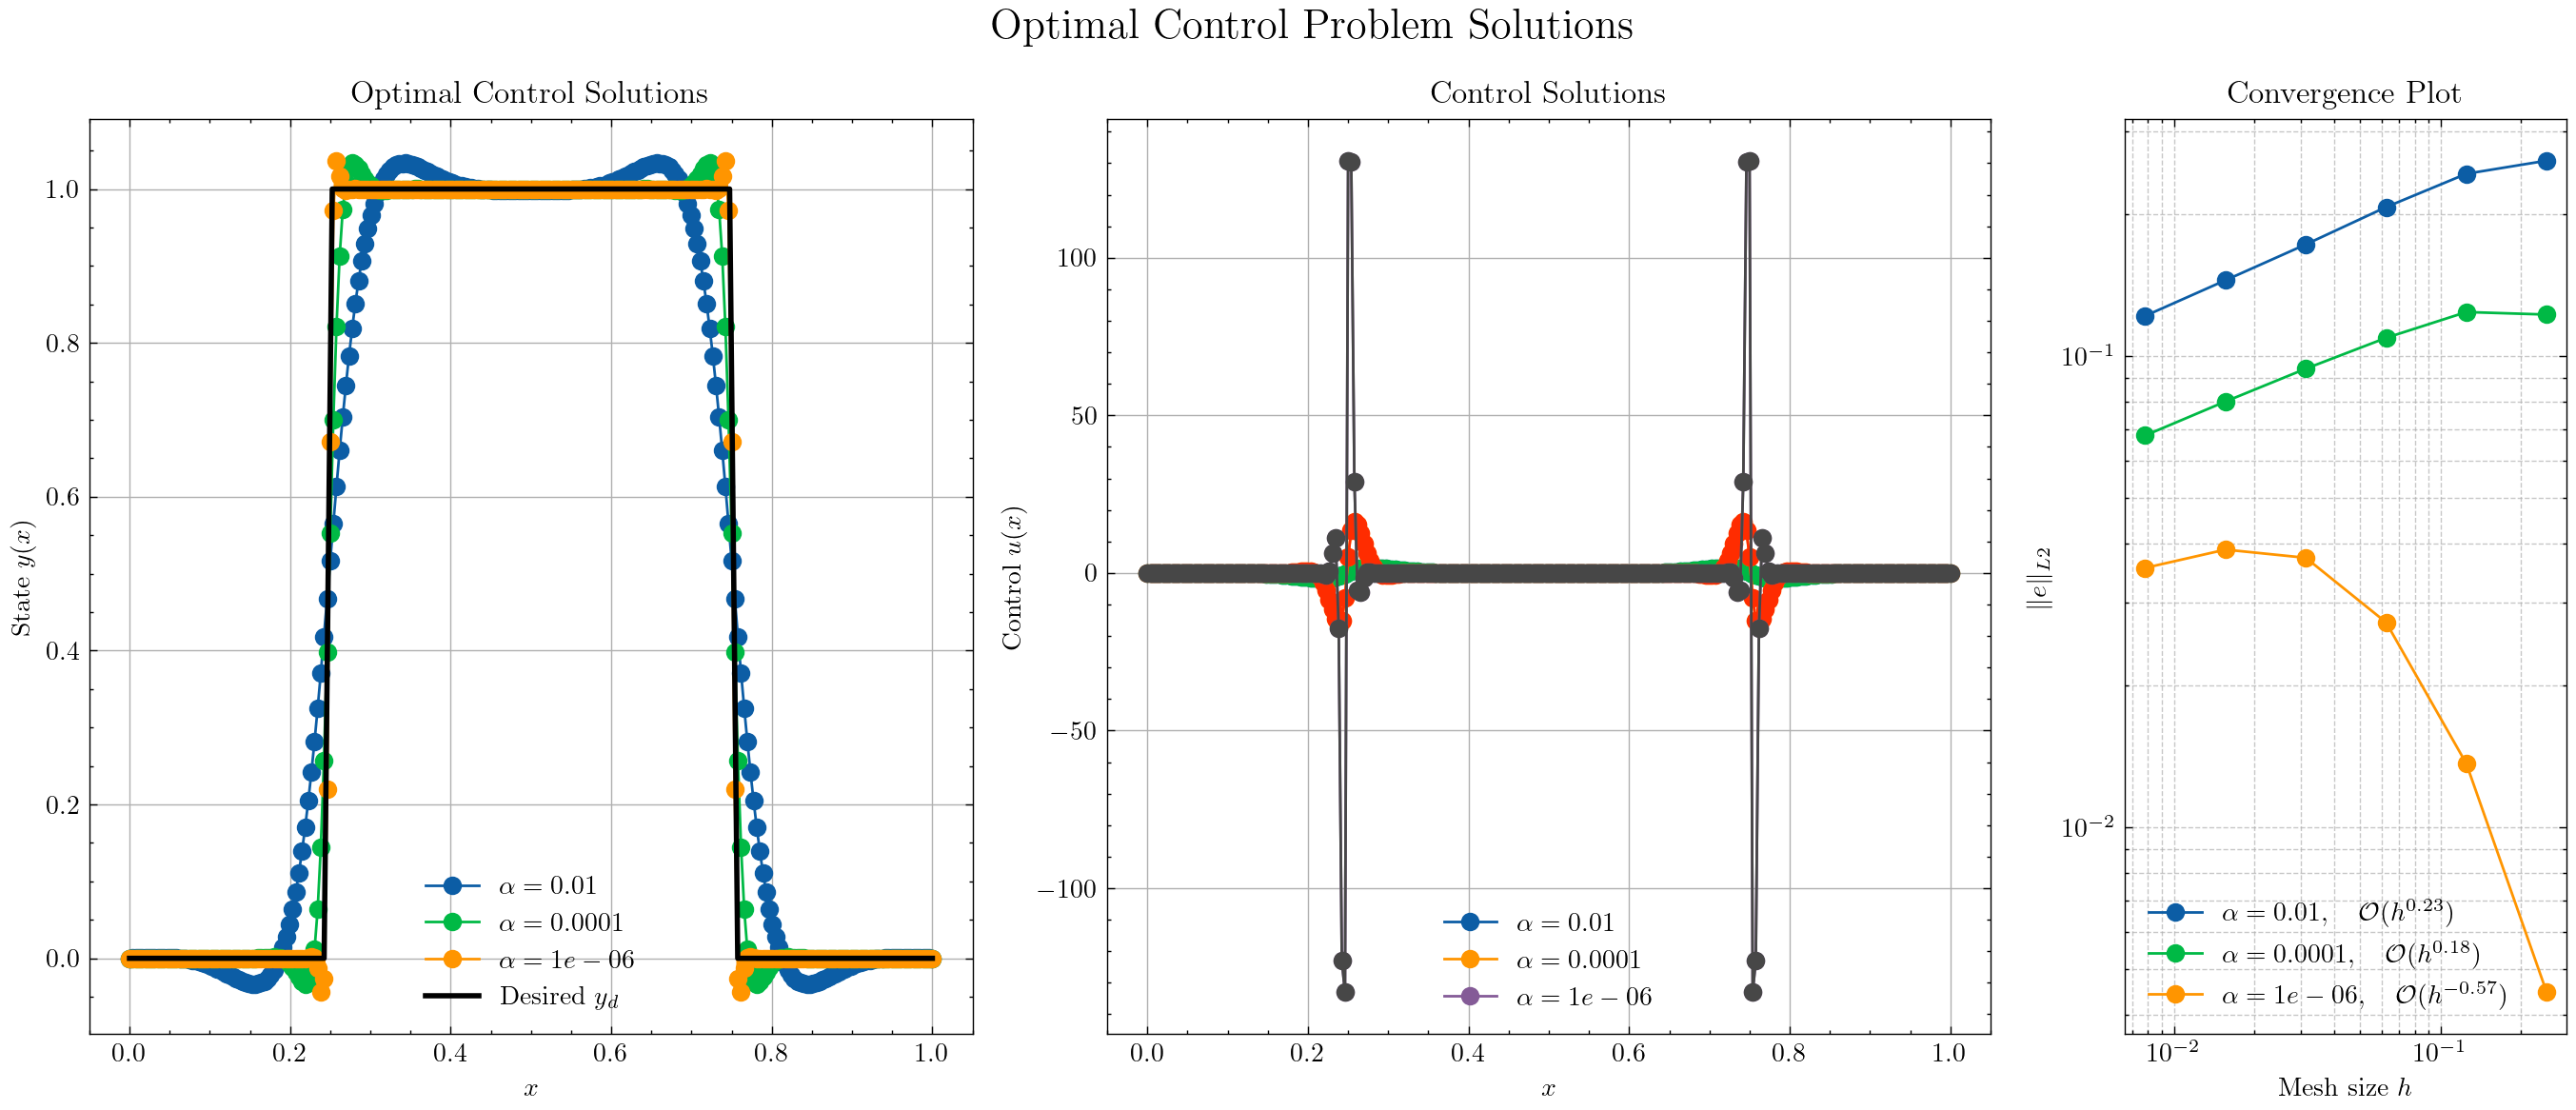

In [8]:
from problem_2.OCP import print_convergence, plot_opt_control_multi

def yd_case1(x): 
    return 0.5 * x * (1 - x)

def yd_case2(x): 
    return np.ones_like(x)

def yd_case3(x): 
    return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

cases = [(yd_case1, "Case 1"),
         (yd_case2, "Case 2"),
         (yd_case3, "Case 3")]


alphas = [1e-2, 1e-4, 1e-6]
n_elements = 50
solver = FEMSolver(n_elements)
n_vals = [4, 8, 16, 32, 64, 128]

for yd_case, title in cases:
    print_convergence(solver, yd_case, alphas, n_vals)
    plot_opt_control_multi(alphas, n_vals, yd_case, fine_mesh=100, savefig=False, name=title)
    print("\n")

